In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD

from scipy.optimize import least_squares as ls
from rbergomi import rBergomi
from scipy.optimize import minimize

In [2]:
spot = np.array(pd.read_csv("spot.csv").Spot)
S0 = spot[0]

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = moneyness*S0/100
log_moneyness = np.log(moneyness/100)

rB_iv = np.array(pd.read_csv("rB_iv_local.csv"))
rB_param = np.array(pd.read_csv("rB_parameters_local.csv"))

nr = len(maturities)

In [3]:
def price(S, K, N, r, q, T):
    N = len(K)
    p = np.zeros(N)
    for i in range(N):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [4]:
start_time_all = time.time()
rB_skew = np.zeros(nr)
N = 25000; n = 1500;
t = np.zeros(nr)
h = 1e-3; K_skew = np.array([S0*(1+h), S0*(1-h)]);

for i in range(nr):
    
    start_time = time.time()
    
    #vol = IV[i]; 
    T = maturities[i];
    
    if T > 0.5:
        n = 1000
    if T > 1:
        n = 365
    
    r = iD.r(T); q = iD.q(T);
    
    def rb(x):
    
        np.random.seed(0)

        H, eta, rho = x
        alpha = H - 0.5

        rB = rBergomi(n, N, T, alpha)
        
        xi = vc.variance_curve(rB.t[0])
        
        dW1 = rB.dW1(); dW2 = rB.dW2();
        Ya = rB.Y(dW1)
        dZ = rB.dZ(dW1, dW2, rho)
        V = rB.V(Ya, xi, eta)
        S = rB.S(V, dZ, r, q, S0)

        P = price(S, K_skew, N, r, q, T)
        
        rB_v = bs.BSImpliedVol(S0, K_skew, T, r, q, P, Option_type = 1, toll = 1e-10)

        return rB_v
    
    rB_skew[i] = np.abs(np.diff(rb(rB_param[i,:])))/(2*h)
    
    t[i] = time.time() - start_time

    print(f'Iteration: {i}\t Elapsed time: {t[i]: .0f} s')

total_time = (time.time() - start_time_all)/60

print(f'\nTotal execution time: {total_time: .0f} minutes')

Iteration: 0	 Elapsed time:  0 s
Iteration: 1	 Elapsed time:  1 s
Iteration: 2	 Elapsed time:  1 s
Iteration: 3	 Elapsed time:  2 s
Iteration: 4	 Elapsed time:  2 s
Iteration: 5	 Elapsed time:  2 s
Iteration: 6	 Elapsed time:  3 s
Iteration: 7	 Elapsed time:  3 s
Iteration: 8	 Elapsed time:  6 s
Iteration: 9	 Elapsed time:  6 s
Iteration: 10	 Elapsed time:  6 s
Iteration: 11	 Elapsed time:  4 s
Iteration: 12	 Elapsed time:  5 s
Iteration: 13	 Elapsed time:  5 s
Iteration: 14	 Elapsed time:  5 s
Iteration: 15	 Elapsed time:  6 s
Iteration: 16	 Elapsed time:  7 s
Iteration: 17	 Elapsed time:  8 s
Iteration: 18	 Elapsed time:  8 s
Iteration: 19	 Elapsed time:  3 s
Iteration: 20	 Elapsed time:  3 s
Iteration: 21	 Elapsed time:  4 s
Iteration: 22	 Elapsed time:  5 s
Iteration: 23	 Elapsed time:  10 s
Iteration: 24	 Elapsed time:  17 s
Iteration: 25	 Elapsed time:  26 s
Iteration: 26	 Elapsed time:  25 s
Iteration: 27	 Elapsed time:  44 s
Iteration: 28	 Elapsed time:  67 s
Iteration: 29	 Ela

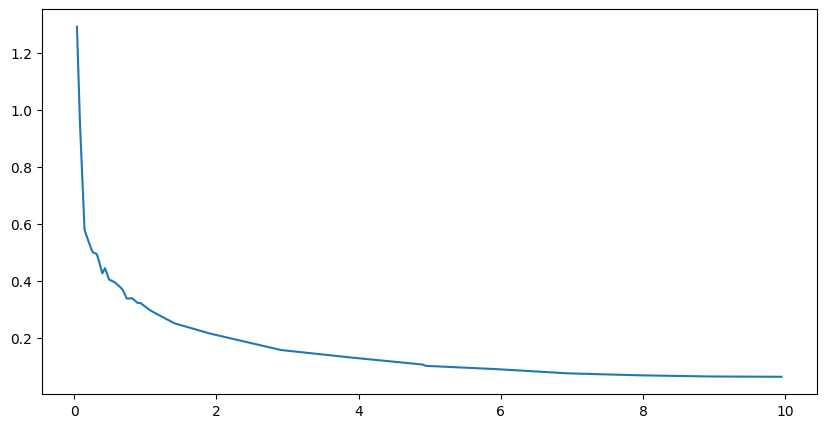

In [6]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(maturities, rB_skew)

In [5]:
df = pd.DataFrame(rB_skew)
df.to_csv("rB_skew.csv", index = False)